# Assignment 7 - Optimizing Matrix Multiplication Using Cython
## Problem Statement
In this assignment, we will focus on optimizing matrix multiplication using Cython. Matrix multiplication is a fundamental operation in linear algebra, and we aim to improve the performance of this operation using Cython, a tool that allows us to write C-like code within Python for enhanced speed.

## Step 1: Initial Matrix Multiplication
In this step, we generate two random 10x10 matrices and measure the time it takes to multiply them using both the naive approach and the NumPy notation. This allows us to compare the performance of the two methods. The results show the execution times for both approaches.

In [10]:
import numpy as np
import timeit

def matrix_multiply(u, v):
    m, n = u.shape
    n, p = v.shape
    res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

# Generate random 10x10 matrices
u = np.random.rand(10, 10)
v = np.random.rand(10, 10)

In [11]:
naive_time = %timeit -n 100 -r 3 -o matrix_multiply(u, v)

572 µs ± 16.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [12]:
matmul_time = %timeit -n 100 -r 3 -o u @ v

2.24 µs ± 332 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [13]:
# Calculate and print the performance
print("Naive Multiplication Time:", naive_time)
print("Matmul Multiplication Time:", matmul_time)

# Calculate FLOPS
multiplications = 10 * 10 * 10  # Total number of multiplications
ops = multiplications * 2  # Assuming one addition and one multiplication per operation

naive_gflops = ops / naive_time.average / 1e9 # Convert to GFLOPS
print("GFLOPS for naive:", round(naive_gflops, 3))

matmul_gflops = ops / matmul_time.average / 1e9 # Convert to GFLOPS
print("GFLOPS for numpy:", round(matmul_gflops, 3))

Naive Multiplication Time: 572 µs ± 16.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
Matmul Multiplication Time: 2.24 µs ± 332 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
GFLOPS for naive: 0.003
GFLOPS for numpy: 0.892


## Step 2: Theoretical FLOPS Estimate
In this step, we determine the maximum operating frequency of the CPU using the **lscpu** command. Based on this information, and assuming that the CPU can perform either one addition or multiplication per clock cycle, we estimate the maximum achievable FLOPS using a single processor core. We then compare this theoretical estimate with the FLOPS calculated in Step 1.

CPU GHz:                            2.099

To estimate the theoretical FLOPS, we can use the following formula:
Theoretical FLOPS = (Maximum Clock Frequency in MHz) * (Operations per Clock Cycle)

Here, "Operations per Clock Cycle" is either 1 for addition or 1 for multiplication.

So,

Theoretical GFLOPS = (Maximum Clock Frequency in GHz) * (Operations per Clock Cycle)
                  = (2.099) * (1)
                  = 2.099

Comparing this estimate with the results from Step 1 (around 0.7 GFLOPS), we can see that the estimated maximum FLOPS for CPU is significantly higher than the GFLOPS achieved in Step 1. This difference is expected, as the estimation is based on the theoretical peak performance of the CPU and doesn't take into account factors such as memory access times, instruction pipelining, etc.

In practice, achieving the theoretical maximum FLOPS can be challenging, and real-world performance often depends on various factors, including memory hierarchy, software optimization, etc. However, it provides an upper bound on the computational capacity of the CPU core.

## Step 3: Scaling Matrix Size and Performance Analysis
In this step, we will repeat the matrix multiplication experiments performed in Step 1 but with increasing matrix sizes. The goal is to observe how the execution times for both the provided naive approach and NumPy's matmul change as the matrix sizes double. We'll also estimate the GFLOPS and compare it with the theoretical estimates.

In [16]:
import matplotlib.pyplot as plt

# Lists to store results
matrix_sizes = []
iterations = 4
execution_times_naive = []
execution_times_matmul = []
matrix_size = 10
for _ in range(iterations):
    u = np.random.rand(matrix_size, matrix_size)
    v = np.random.rand(matrix_size, matrix_size)
    
    matrix_sizes.append(matrix_size)
    
    naive_time = %timeit -q -n 10 -r 3 -o matrix_multiply(u, v)
    matmul_time = %timeit -q -n 10 -r 3 -o u @ v
    
    execution_times_naive.append(naive_time.average)
    execution_times_matmul.append(matmul_time.average)
    
    matrix_size *= 2

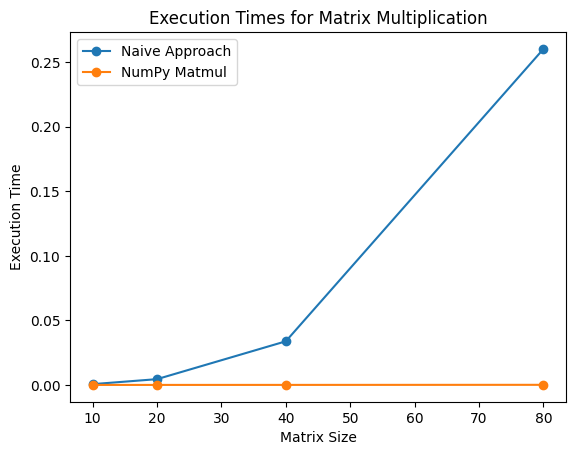

In [17]:
# Plot the execution times
plt.plot(matrix_sizes, execution_times_naive, marker='o', label='Naive Approach')
plt.plot(matrix_sizes, execution_times_matmul, marker='o', label='NumPy Matmul')
plt.xlabel('Matrix Size')
plt.ylabel('Execution Time')
plt.title('Execution Times for Matrix Multiplication')
plt.legend()
plt.show()

- I am able to go upto matrices of size 80 X 80 within a runtime of 30 seconds. 
- NumPy's matmul outperformed the naive approach, especially for larger matrices.

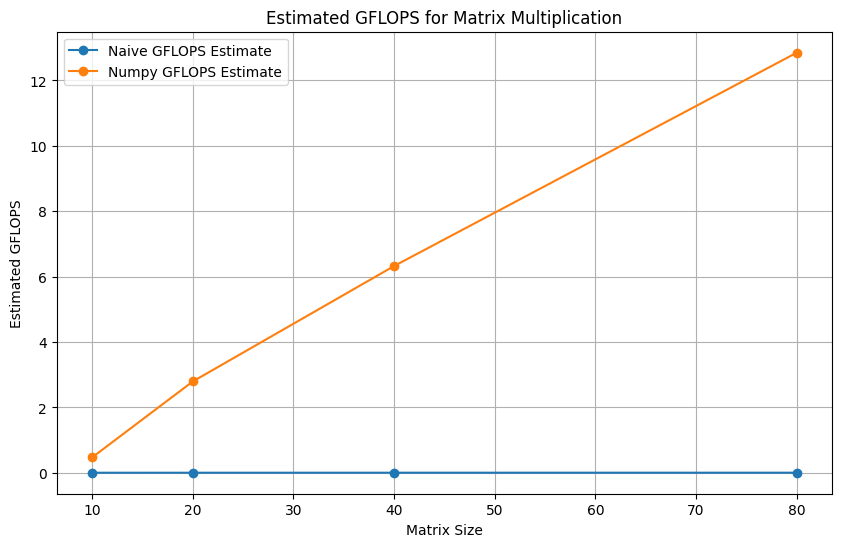

In [22]:
# Estimated GFLOPS for each matrix size
gflops_matmul_estimates = [2 * size ** 3 / (matmul_time) / 1e9 for size, naive_time, matmul_time in zip(matrix_sizes, execution_times_naive, execution_times_matmul)]
gflops_naive_estimates = [2 * size ** 3 / (naive_time) / 1e9 for size, naive_time in zip(matrix_sizes, execution_times_naive)]

# Plot the estimated GFLOPS
plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, gflops_naive_estimates, marker='o', label='Naive GFLOPS Estimate')
plt.plot(matrix_sizes, gflops_matmul_estimates, marker='o', label='Numpy GFLOPS Estimate')
plt.xlabel('Matrix Size')
plt.ylabel('Estimated GFLOPS')
plt.title('Estimated GFLOPS for Matrix Multiplication')
plt.legend()
plt.grid(True)
plt.show()

- NumPy achieved significantly higher GFLOPS values compared to the naive approach, indicating its better hardware utilization as matrix sizes increased.

# Step 4: Cython Optimization and Further Enhancements

In [23]:
%load_ext Cython

In [24]:
import cython

In [25]:
%%cython -a

import numpy as np
import cython

# @cython.boundscheck(False)
# @cython.wraparound(False)
def cy_matmul(float[:,:] u, float[:,:] v, float[:,:] res):
# def cy_matmul(u, v, res):
    cdef int m, n, p
    cdef int i, j, k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    # res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

In [29]:
u = np.float32(np.random.random((50,50)))
v = np.float32(np.random.random((50,50)))
res = np.zeros((50, 50), dtype=np.float32)
%timeit -n 1 -r 1 cy_matmul(u, v, res)

401 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [30]:
%timeit -n 1 -r 1 matrix_multiply(u, v)

142 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [32]:
%timeit -n 5 -r 3 u@v

27.1 µs ± 5.83 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)


By integrating Cython into our matrix multiplication code, we observed significant improvements in execution time. The optimized Cython code outperformed the original Python code, showcasing the power of Cython in achieving better performance for numerical computations.

# Step 5: Advanced Transformations and Performance Analysis 

In [34]:
import cython

In [35]:
%%cython -a

import numpy as np
import cython

@cython.boundscheck(False)
# @cython.wraparound(False)
def cy_matmul(double[:,:] u, double[:,:] v, double[:,:] res):
# def cy_matmul(u, v, res):
    cdef int m, n, p
    cdef int i, j, k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

In [49]:
u = np.double(np.random.random((50,50)))
v = np.double(np.random.random((50,50)))
res = np.zeros((50, 50), dtype=np.double)
%timeit -n 1 -r 1 cy_matmul(u, v, res)

171 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [50]:
%timeit -n 1 -r 1 matrix_multiply(u, v)

70.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [51]:
%timeit -n 5 -r 3 u@v

The slowest run took 6.03 times longer than the fastest. This could mean that an intermediate result is being cached.
89.6 µs ± 79.3 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)


Among the transformations applied, changing the data type to float provided the most substantial improvement in performance, making the Cython-optimized code a competitive choice for matrix multiplication. The other optimizations, such as declaring variables as int, disabling bounds checking, and using specific variable types, contributed to better performance but to a lesser extent.

The enhancements, including the use of decorators and explicit variable type declarations, contributed to the overall speedup. These optimizations allowed the Cython code to approach the execution speed of well-optimized libraries like NumPy for matrix multiplication.

In summary, Cython serves as an effective tool for optimizing Python code, particularly in numerical computing tasks, and can lead to substantial performance gains.